<a href="https://colab.research.google.com/github/wagner1986/PapyrusTech/blob/main/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install kornia
!pip install kornia_moons

In [26]:
from abc import ABC, abstractmethod
from typing import Any, List, Tuple
from itertools import product
import numpy as np
import torch

class IPreprocessor(ABC):
    """
    Interface para um pré-processador de imagens.
    Define o contrato para classes que implementam operações de pré-processamento em imagens.
    """

    @abstractmethod
    def __call__(self, image: torch.Tensor) -> torch.Tensor:
        """
        Aplica operações de pré-processamento à imagem fornecida.

        Parâmetros:
            image (torch.Tensor): A imagem de entrada como um tensor do PyTorch.

        Retorna:
            torch.Tensor: A imagem após o pré-processamento.
        """
        pass

class IGlobalFeatureStructurer(ABC):
    """
    Interface para a estruturação global de features através de grafo.
    """

    @abstractmethod
    def __call__(self, points: np.ndarray, featuresByPoints: np.ndarray) -> Tuple[np.ndarray,Any]:
        """
        Estrutura features globais de uma imagem em um grafo, utilizando pontos e suas características associadas.

        Args:
            points (np.ndarray): Array de pontos extraídos de uma imagem, onde cada ponto é uma coordenada 2D.
            featuresByPoints (np.ndarray): Array de características associadas a cada ponto.

        Returns:
            Tuple[np.ndarray, Any]: Um grafo representando a estruturação global das features e o objeto Delaunay utilizado para a triangulação.
        """
        pass

class IGlobalMatcher(ABC):
    """
    Interface para a similaridade global de features através de grafo.
    """
    @abstractmethod
    def __call__(self, matrixAdj0: np.ndarray, matrixAdj1: np.ndarray, threshold: float = 0.2) -> int:
        """
        Interface para invocar operações de comparação de grafos.

        Args:
            matrixAdj0: A primeira matriz de adjacência do grafo.
            matrixAdj1: A segunda matriz de adjacência do grafo.
            threshold: O limiar para avaliar correspondências.

        Returns:
            Um valor representando a similaridade entre os dois grafos.
        """
        pass


import torch
from kornia.feature import LocalFeature, DescriptorMatcher
from typing import Dict, Optional

class MyLocalFeatureMatcher:
    def __init__(self, local_feature: LocalFeature, descriptor_matcher: DescriptorMatcher):
        """
        Inicializa o matcher de características locais com um objeto LocalFeature para extração de características
        e um objeto DescriptorMatcher para o matching de descritores.

        Parâmetros:
            local_feature (LocalFeature): Um objeto LocalFeature para extração combinada de detector e descritor.
            descriptor_matcher (DescriptorMatcher): Um objeto DescriptorMatcher configurado para o matching de descritores.
        """
        self.local_feature = local_feature
        self.descriptor_matcher = descriptor_matcher

    def __call__(self, image0: torch.Tensor, image1: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Extrai e match keypoints e descritores entre duas imagens.

        Args:
            image0: Primeira imagem.
            image1: Segunda imagem.

        Returns:
            Dicionário com keypoints, descritores e matches.
        """
        lafs0, responses0, descriptors0 = self.local_feature(image0)
        lafs1, responses1, descriptors1 = self.local_feature(image1)
        distance, matches = self.descriptor_matcher(descriptors0[0], descriptors1[0])

        return {
            "keypoints0": lafs0[0, :, :, 2].data,#[N, 2])
            "keypoints1": lafs1[0, :, :, 2].data,#[N, 2])
            "lafs0": lafs0,#[1, N, 2, 3]
            "lafs1": lafs1,#[1, N, 2, 3]
            "descriptors0": descriptors0[0],#[N, 128])
            "descriptors1": descriptors1[0],#[N, 128])
            "matches": matches,#[M, 2])
        }


class MyDrawMatcher:
  def __init__(self,draw_dict=None) -> None:
      if draw_dict is None:
        draw_dict = {
            "inlier_color": (0.2, 1, 0.2),
            "tentative_color": (1.0, 0.5, 1),
            "feature_color": (0.6, 0.5, 0),
            "vertical": False,
        }
      self.draw_dict = draw_dict

  def __call__(self,img1_preprocessed, img2_preprocessed, output) -> None:
        from kornia_moons.viz import draw_LAF_matches
        # Use kornia.tensor_to_image to ensure the images are in the correct format for drawing
        img1 = K.tensor_to_image(img1_preprocessed.squeeze())
        img2 = K.tensor_to_image(img2_preprocessed.squeeze())
        # Assumes draw_LAF_matches is accessible and compatible with provided arguments
        draw_LAF_matches(
            output['lafs0'],
            output['lafs1'],
            output['matches'],
            img1,
            img2,
            None,  # Or the inliers if available
            self.draw_dict
        )

In [27]:
import torch.nn as nn
import torchvision
import kornia as K

class PreprocessPipeline(IPreprocessor):
    def __init__(self):
        super(PreprocessPipeline, self).__init__()
        self.transforms = nn.Sequential(
            # Normaliza a imagem para ter valores no intervalo [0, 1]
            K.enhance.Normalize(0.0, 255.0),
            # Redimensiona a imagem para o tamanho desejado
            K.geometry.Resize((200, 200)),
            # Converte a imagem RGB para escala de cinza
            K.color.RgbToGrayscale(),
        )

    def __call__(self, image: torch.Tensor) -> torch.Tensor:
        # Normaliza a imagem para ter valores no intervalo [0, 1]
        x = image.float() / 255.0  # Garante que a operação de divisão é realizada em float
        # Aplica as transformações definidas em __init__
        x = self.transforms(x)
        # Adiciona uma dimensão de batch no início se ainda não houver
        if x.ndim == 3:
            x = x.unsqueeze(0)
        return x

import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
class DelaunayGraph(IGlobalFeatureStructurer):
    @staticmethod
    def distancePoint(p1, p2):
        return math.hypot(p1[0] - p2[0], p1[1] - p2[1])

    def buildConnection(self,tri):
        mapConnection = []
        for simplice in tri.simplices:
            mapConnection.extend([
                [simplice[0], simplice[1]],
                [simplice[1], simplice[2]],
                [simplice[2], simplice[0]]
            ])
        return mapConnection

    def buildMapGraph(self, mapConex,featuresByPoints):
        size = len(featuresByPoints)
        sample = np.matrix(np.ones((size, size)) * np.inf)
        for i in range(size):
            sample[i, i] = 0
        for conexao in mapConex:
            distance = self.distancePoint(featuresByPoints[conexao[0]], featuresByPoints[conexao[1]])
            sample[conexao[0], conexao[1]] = distance
        return sample

    @staticmethod
    def plot_delaunay(points, tri):
        plt.triplot(points[:, 0], points[:, 1], tri.simplices.copy(), color='orange')
        plt.plot(points[:, 0], points[:, 1], 'o')
        dist = 3
        for i, point in enumerate(points):
            plt.text(point[0] + dist, point[1] + dist, f' {i}', color='red', fontsize=12)
        plt.show()

    def __call__(self, points, featuresByPoints):
        # Assume-se que os pontos são extraídos de uma imagem e já processados
        tri = Delaunay(points)
        mapConnection = self.buildConnection(tri)
        graph = self.buildMapGraph(mapConnection,featuresByPoints)
        return graph,tri


from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import floyd_warshall
class FloydWarshall(IGlobalMatcher):
    @staticmethod
    def floydWarshall(graph):
        graph = csr_matrix(graph)
        dist_matrix, _ = floyd_warshall(csgraph=graph, directed=False, return_predecessors=True)
        return dist_matrix

    @staticmethod
    def match_matrix(mat_a, mat_b, threshold):
        mat_dist = mat_b - mat_a
        for i in range(mat_dist.shape[0]):
            mat_dist[i, :i] = 0  # Zera a metade inferior da matriz para evitar duplicação
        mat_dist = mat_dist * mat_dist  # Eleva as diferenças ao quadrado
        points = 0
        for i in range(mat_dist.shape[0]):
            for j in range(i + 1, mat_dist.shape[0]):
                if mat_dist[i, j] < threshold:
                    points += 1
        return points

    def __call__(self,matrixAdj0,matrixAdj1, threshold=0.2):
        matAdjFull0 = self.floydWarshall(matrixAdj0)
        matAdjFull1 = self.floydWarshall(matrixAdj1)
        simGraph = self.match_matrix(matAdjFull0,matAdjFull1,threshold)
        return simGraph


In [28]:
class ImageComparisonPipeline:
    __slots__ = ['preprocessor', 'local_feature_matcher', 'global_structurer', 'global_matcher']

    def __init__(self, preprocessor: IPreprocessor = None, local_feature_matcher: MyLocalFeatureMatcher = None, global_structurer: IGlobalFeatureStructurer = None, global_matcher: IGlobalMatcher = None):
        self.preprocessor = preprocessor
        self.local_feature_matcher = local_feature_matcher
        self.global_structurer = global_structurer
        self.global_matcher = global_matcher

    def process_global(self,out,index):
        pts = out[f'keypoints{index}'][out['matches'][:, index]].detach().numpy()  # Pontos de keypoints correspondentes
        desc = out[f'descriptors{index}'][out['matches'][:, index]].detach().numpy()  # Descritores dos keypoints correspondentes
        matrixAdj, tri = self.global_structurer(pts, desc)
        return matrixAdj

    def run(self, image1: Any, image2: Any,log=None) -> float:
        if not all([self.preprocessor, self.local_feature_matcher, self.global_structurer, self.global_matcher]):
            raise ValueError("Pipeline components are not fully set.")
        image1_processed, image2_processed = map(self.preprocessor, (image1, image2))

        # Realiza o matching de características entre as duas imagens processadas
        out = self.local_feature_matcher(image1_processed,image2_processed)

        if log is not None and log in ('DEBUG','INFO'):
          print(out['keypoints1'].shape,type(out['keypoints1']),'\n',
                out['lafs1'].shape,type(out['lafs1']),'\n',
                out['descriptors1'].shape,type(out['descriptors1']),'\n',
                out['matches'].shape,)

        if log is not None and log in ('DEBUG'):
          draw = MyDrawMatcher()
          draw(image1_processed,image2_processed,out)
        try:
          matrixAdj0 = self.process_global(out,0)
          matrixAdj1 = self.process_global(out,1)
          score = self.global_matcher(matrixAdj0, matrixAdj1, threshold=0.005)
        except:
          score = 0
        return score


class ImageSearchEvaluator:
    def __init__(self, pipeline: ImageComparisonPipeline):
        self.pipeline = pipeline

    def data_augmentation(self, dataset: List[str]) -> List[str]:
        # Implemente a operação de data augmentation para gerar o dataset de inspeção
        dataset_de_inspecao = dataset  # Aqui você deve implementar a lógica de data augmentation
        return dataset_de_inspecao

    def evaluate_accuracy(self, dataset_de_referencia: List[str], dataset_de_inspecao: List[str]) -> float:
        total_correspondencias_corretas = 0
        total_correspondencias = 0

        for indice_imagem_inspecao, imagem_de_inspecao in enumerate(dataset_de_inspecao):
            # Realize uma busca sobre o dataset de referência para encontrar a correspondência
            melhor_correspondencia = None
            melhor_score = float('-inf')
            print("fase {}".format(indice_imagem_inspecao))
            for indice_imagem_referencia, imagem_de_referencia in enumerate(dataset_de_referencia):
                try:
                    similarity_score = self.pipeline.run(imagem_de_referencia, imagem_de_inspecao)
                    if similarity_score > melhor_score:
                        melhor_score = similarity_score
                        melhor_correspondencia = indice_imagem_referencia
                except Exception as e:
                    print(f"Erro durante a execução do pipeline: {e}")
                print(indice_imagem_inspecao,melhor_correspondencia)

            # Verifique se a correspondência encontrada está correta
            if melhor_correspondencia == indice_imagem_inspecao:
                total_correspondencias_corretas += 1
            total_correspondencias += 1


        # Compute a acurácia do pipeline na busca das correspondências corretas
        accuracy = total_correspondencias_corretas / total_correspondencias if total_correspondencias > 0 else 0
        return accuracy



In [35]:
from kornia.feature import LocalFeatureMatcher,GFTTAffNetHardNet
from kornia import tensor_to_image  # Importa função para converter tensor PyTorch em imagem numpy

# Carregar as duas imagens utilizando torchvision
image1 = torchvision.io.read_image("image1.jpg").float()
image2 = torchvision.io.read_image("image2.jpg").float()

preprocess = PreprocessPipeline()
drawMatch = MyDrawMatcher()
# Configura o extrator de características locais e o matcher de descritores
customFeatureMatcher = MyLocalFeatureMatcher(
    GFTTAffNetHardNet(25), K.feature.DescriptorMatcher('smnn', 0.95)
)

delaunayG = DelaunayGraph()  # Inicializa o construtor de grafo de Delaunay
# Compara as matrizes de distância dos dois grafos
floyd = FloydWarshall()

torch.Size([25, 2]) <class 'torch.Tensor'> 
 torch.Size([1, 25, 2, 3]) <class 'torch.Tensor'> 
 torch.Size([25, 128]) <class 'torch.Tensor'> 
 torch.Size([10, 2])
Similarity Score: 24
fase 0
0 0
0 0
fase 1
1 0
1 1
Acurácia do pipeline na busca das correspondências corretas: 1.0


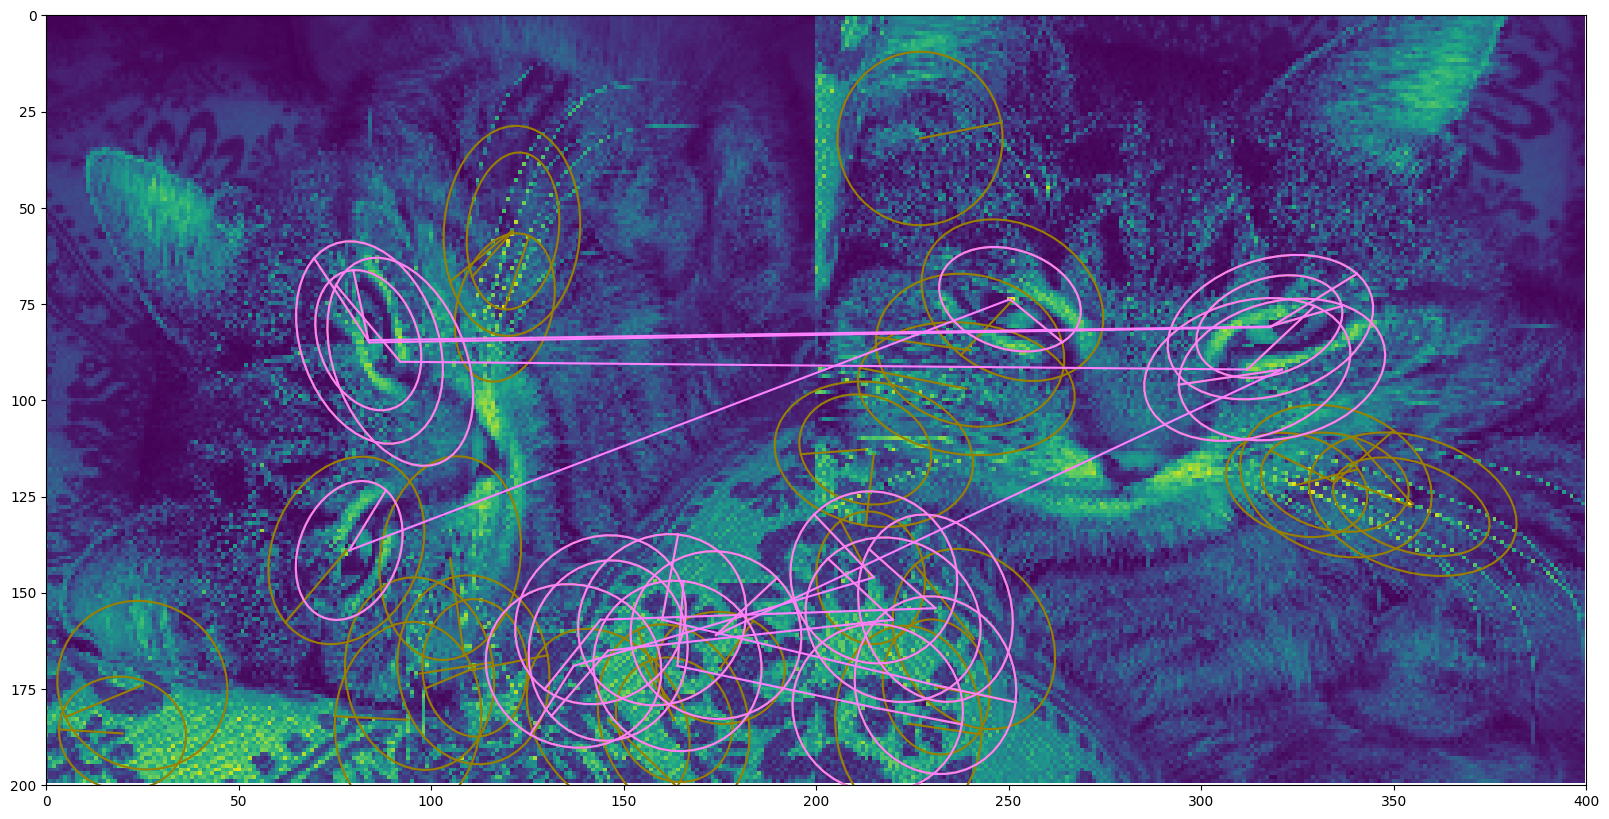

In [36]:

# Exemplo de uso:

pipeline = ImageComparisonPipeline(preprocess,customFeatureMatcher,delaunayG,floyd)

try:
    similarity_score = pipeline.run(image1, image2, log='DEBUG')
    print(f"Similarity Score: {similarity_score}")
except Exception as e:
    print(f"Erro durante a execução do pipeline: {e}")



evaluator = ImageSearchEvaluator(pipeline)
# Suponha que você tenha um dataset de referência e queira usar o mesmo dataset para gerar o dataset de inspeção
dataset_de_referencia = [image1,image2]  # Lista de tensores de imagem representando o dataset de referência
dataset_de_inspecao = evaluator.data_augmentation(dataset_de_referencia)

# Calcule a acurácia do pipeline na busca das correspondências corretas
accuracy = evaluator.evaluate_accuracy(dataset_de_referencia, dataset_de_inspecao)
print(f"Acurácia do pipeline na busca das correspondências corretas: {accuracy}")
